<a href="https://colab.research.google.com/github/LeeDanielSeungjae/TransformerSNP500/blob/develop/snp500_20210120.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

from IPython.display import display
from IPython.display import SVG, Image


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
raw_data = pd.read_csv('./drive/MyDrive/graph/GSPC.csv')
raw_data['Date'] = pd.to_datetime(raw_data['Date'])
raw_data.set_index('Date',inplace=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


volume = 주식 거래량 \
open = 장 시작\
close = 장 마감\
high = 장중 최고거래액\
low = 장중 최저거래액

전체 데이터 shape:(1522, 6)


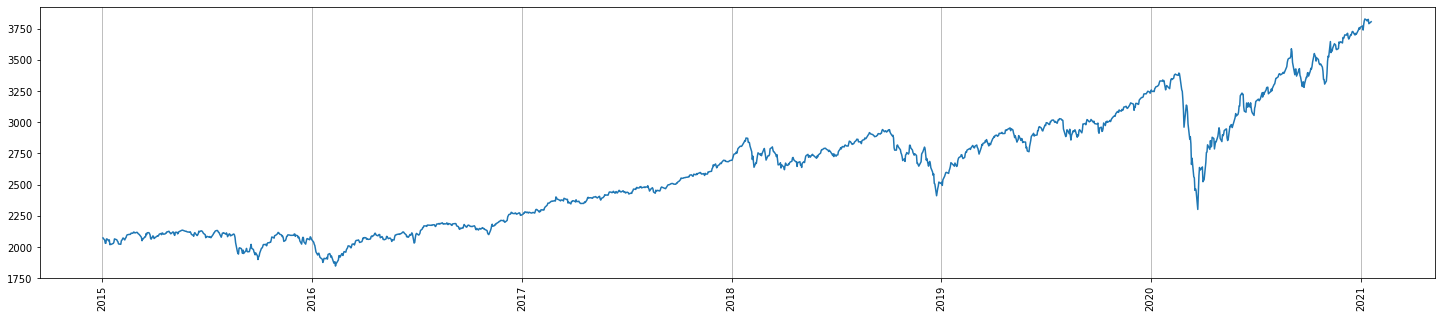

In [ ]:
print("전체 데이터 shape:{}".format(raw_data.shape))
plt.figure(figsize=(25,5))
plt.plot(raw_data['High'])
plt.xticks(rotation=90)
plt.grid(axis='x')

In [ ]:
output_window = 5
input_window = 200

In [ ]:
X_cols = list(raw_data.columns)
X_cols.remove('High')

test_data_size = 376
X = raw_data[X_cols]
y = raw_data['High']

print(y)

scaler = StandardScaler()
Xscaler = scaler.fit(X)
#yscaler = scaler.fit(y.values.reshape(-1,1))

X = Xscaler.transform(X)
#y = yscaler.transform(y.values.reshape(-1,1))

y = scaler.fit_transform(y.to_numpy().reshape(-1,1)).reshape(-1)

X_train, X_test = X[:-test_data_size], X[-test_data_size:]
y_train, y_test = y[:-test_data_size], y[-test_data_size:]

print("train set :",X_train.shape)
print("test set :",X_test.shape)
print("train set : ",y_train.shape)

y_train

Date
2015-01-02    2072.360107
2015-01-05    2054.439941
2015-01-06    2030.250000
2015-01-07    2029.609985
2015-01-08    2064.080078
                 ...     
2021-01-12    3810.780029
2021-01-13    3820.959961
2021-01-14    3823.600098
2021-01-15    3788.729980
2021-01-19    3804.530029
Name: High, Length: 1522, dtype: float64
train set : (1146, 5)
test set : (376, 5)
train set :  (1146,)


array([-1.13976164, -1.17831624, -1.23036003, ...,  0.86897423,
        0.83603518,  0.8687158 ])

#**seq data 형성함수**
>create sequence 시퀀스를 생성한다 \
 그리고 sequence로 바꾼다.

In [ ]:
def create_sequences1(array, tw):
  res = []
  L = len(array)
  for i in range(L - tw ):
    tr_seq = np.append(array[i:i + tw][ : -output_window] , output_window*[0])
    train_label = array[i:i+tw]
    res.append((tr_seq, train_label))
  return torch.FloatTensor(res)

In [ ]:
seq_len = input_window
#X_train = create_sequences1(X_train, seq_len)
y_train_seq = create_sequences1(y_train, seq_len)
#X_test = create_sequences1(X_test, seq_len)
y_test_seq = create_sequences1(y_test, seq_len)

y_train_seq = y_train_seq[:-output_window]
y_test_seq = y_test_seq[:-output_window]


In [ ]:
y_train_seq

tensor([[[-1.1398, -1.1783, -1.2304,  ...,  0.0000,  0.0000,  0.0000],
         [-1.1398, -1.1783, -1.2304,  ..., -1.2749, -1.2435, -1.2233]],

        [[-1.1783, -1.2304, -1.2317,  ...,  0.0000,  0.0000,  0.0000],
         [-1.1783, -1.2304, -1.2317,  ..., -1.2435, -1.2233, -1.2213]],

        [[-1.2304, -1.2317, -1.1576,  ...,  0.0000,  0.0000,  0.0000],
         [-1.2304, -1.2317, -1.1576,  ..., -1.2233, -1.2213, -1.2113]],

        ...,

        [[ 0.6921,  0.6924,  0.7079,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.6921,  0.6924,  0.7079,  ...,  0.8171,  0.8624,  0.8610]],

        [[ 0.6924,  0.7079,  0.6994,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.6924,  0.7079,  0.6994,  ...,  0.8624,  0.8610,  0.8860]],

        [[ 0.7079,  0.6994,  0.6850,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.7079,  0.6994,  0.6850,  ...,  0.8610,  0.8860,  0.8943]]])

>예시


예시의 create_inout_sequences 역할과 비슷

In [ ]:
#print("X_train :",(X_train.shape))
#print("X_test :",(X_test.shape))
print("y_train :",(y_train_seq.shape))
print("y_test :",(y_test_seq.shape))

y_train : torch.Size([941, 2, 200])
y_test : torch.Size([171, 2, 200])


**MODEL 정의하기**

In [ ]:
class TransformerModel(nn.Module):

  def __init__(self, ninp = 250, nlayers=1, dropout=0.1):
    super(TransformerModel, self).__init__()

    from torch.nn import TransformerEncoder, TransformerEncoderLayer
    
    self.model_type = 'Transformer'
    
    self.src_mask = None
    
    self.pos_encoder = PositionalEncoding(ninp)
    self.encoder_layers = TransformerEncoderLayer(d_model = ninp, nhead = 10, dropout = dropout)
    self.transformer_encoder = TransformerEncoder(self.encoder_layers, num_layers = nlayers)
    #self.encoder = nn.Embedding(ntoken, ninp) #시계열에서 불필요?
    self.decoder = nn.Linear(ninp, 1)

    self.init_weights()

  def _generate_square_subsequent_mask(self, sz):
    mask = (torch.triu(torch.ones(sz,sz))==1).transpose(0,1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

  def init_weights(self):
    initrange = 0.1
    self.decoder.bias.data.zero_()
    self.decoder.weight.data.uniform_(-initrange, initrange)

  def forward(self, src):
    if self.src_mask is None or self.src_mask.size(0) != len(src):
      device = src.device
      mask = self._generate_square_subsequent_mask(len(src)).to(device)
      self.src_mask = mask
    src = self.pos_encoder(src)
    output = self.transformer_encoder(src, self.src_mask)
    output = self.decoder(output)
    return output

**Positional Encoing**


In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, max_len=5000):
    super(PositionalEncoding, self).__init__()

    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0).transpose(0,1)
    self.register_buffer('pe',pe)
  
  def forward(self,x):
    return x + self.pe[:x.size(0), :]

In [ ]:
def get_batch(source, i, batch_size):
  length = min(batch_size, len(source) - 1 - i)
  data = source[i:i+length]
  input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window,1)) #1은 feature size
  target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window,1))
  return input, target

#**Train 생성하기**


In [ ]:
def plot_and_loss(eval_model, data_source, epoch):
  eval_model.eval()
  total_loss = 0.
  test_result = torch.Tensor(0)
  truth = torch.Tensor(0)
  with torch.no_grad():
    for i in range(0,len(data_source) - 1):
      daat, target = get_batch(data_source, i, 1)
      output = eval_model(daat)

      total_loss += criterion(output[-output_window:],target[-output_window:]).item()

      test_result = torch.cat((test_result, output[-1].view(-1).cpu()), 0)
      truth = torch.cat((truth, target[-1].view(-1).cpu()),0)
  
  len(test_result)
  print(test_result)
  plt.plot(test_result, color = "red")
  plt.plot(truth[:50],color="blue")
  plt.plot(test_result-truth, color="green")
  plt.grid(True, which='both')
  plt.axhline(y=0,color='k')
  plt.savefig("./drive/MyDrive/graph/transformer-epoch%d.png"%epoch)
  plt.close()

  return total_loss / i

In [ ]:

batch_size = 40


def train(train_data):
  
  model.train() #학습모드 시작
  total_loss = 0. #total loss 초기화
  start_time = time.time() 
  
  for batch, i in enumerate(range(0, len(train_data) - 1,batch_size)):
    
    data, targets = get_batch(train_data, i, batch_size)
    
    optimizer.zero_grad()
    
    output = model(data)
        
    loss = criterion(output[-output_window:], targets[-output_window:])
    
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(),0.5)
    optimizer.step()

    total_loss += loss.item()
    log_interval = int(len(train_data) / batch_size / 5)
    if batch % log_interval == 0 and batch > 0:
      cur_loss = total_loss / log_interval
      elapsed = time.time() - start_time
      print('| epoch {:3d} | {:5d}/{:5d} batches |'
        'lr {:02.6f} | ms/batch {:5.2f} | '
        'loss {:5.5f} | ppl {:8.2f}'.format
        (epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
        elapsed*1000 / log_interval,
        cur_loss, math.exp(cur_loss)))
      total_loss = 0
      start_time = time.time()

def evaluate(eval_model, data_source):
  eval_model.eval()
  total_loss = 0.
  eval_batch_size = 1000
  with torch.no_grad():
    for i in range(0, len(data_source) - 1, eval_batch_size):
      data, targets = get_batch(data_source, i, eval_batch_size)
      output = eval_model(data)
      total_loss += len(data[0])*criterion(output[-output_window:], targets[-output_window:]).cpu().item()
  return total_loss/len(data_source)

def predict(eval_model, data_source, steps):
  eval_model.eval()
  total_loss = 0.
  test_results = torch.Tensor(0)
  truth = torch.Tensor(0)
  _, data = get_batch(data_source, 0,1)

  with torch.no_grad():
    for i in range(0, steps, 1):
      
      input = torch.clone(data[-input_window:])
      input[-output_window:] = 0

      output = eval_model(data[-input_window:])
      data = torch.cat((data, output[-1:]))

  data = data.cpu().view(-1)

  plt.plot(data, color="red")
  plt.plot(data[:input_window],color="blue")
  plt.grid(True, which='both')
  plt.axhline(y=0, color='k')
  plt.savefig('./drive/MyDrive/graph/transformer-future%d.png'%steps)
  plt.close()

model = TransformerModel().to(device)
train_data = y_train_seq.to(device)
val_data = y_test_seq.to(device)

criterion = nn.MSELoss()
lr = 0.005
optimizer= torch.optim.AdamW(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.95)

best_val_loss = float("inf")
epochs = 100
best_model = None

for epoch in range(1, epochs + 1):
  epoch_start_time = time.time()
  train(train_data)

  if(epoch % 10 is 0):
    val_loss = plot_and_loss(model, val_data, epoch)
    predict(model, val_data, 100)
  else:
    val_loss = evaluate(model, val_data)
  
  ppl=0.0
  try:
    ppl = math.exp(val_loss)
  except OverflowError:
    ppl = float('inf')

  print('-' * 89)
  print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.5f} | valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                          val_loss, ppl))
  print('-' * 89)
  scheduler.step()


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   1 |     4/   23 batches |lr 0.005000 | ms/batch 61.51 | loss 53.11414 | ppl 116729324596259228483584.00
| epoch   1 |     8/   23 batches |lr 0.005000 | ms/batch 33.50 | loss 1.57878 | ppl     4.85
| epoch   1 |    12/   23 batches |lr 0.005000 | ms/batch 34.90 | loss 0.21799 | ppl     1.24
| epoch   1 |    16/   23 batches |lr 0.005000 | ms/batch 34.29 | loss 2.89985 | ppl    18.17
| epoch   1 |    20/   23 batches |lr 0.005000 | ms/batch 35.42 | loss 0.66175 | ppl     1.94
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  0.94s | valid loss 2.53022 | valid ppl    12.56
-----------------------------------------------------------------------------------------
| epoch   2 |     4/   23 batches |lr 0.004513 | ms/batch 43.07 | loss 1.14520 | ppl     3.14
| epoch   2 |     8/   23 batches |lr 0.004513 | ms/batch 33.78 | loss 0.63660 | ppl     1.89
| epoch   2 |    12/   23 batches |lr 0.004513 | ms/batch 34.44 | 

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  11 |     8/   23 batches |lr 0.002844 | ms/batch 34.32 | loss 0.20031 | ppl     1.22
| epoch  11 |    12/   23 batches |lr 0.002844 | ms/batch 34.19 | loss 0.17710 | ppl     1.19
| epoch  11 |    16/   23 batches |lr 0.002844 | ms/batch 34.38 | loss 0.29004 | ppl     1.34
| epoch  11 |    20/   23 batches |lr 0.002844 | ms/batch 34.21 | loss 0.07388 | ppl     1.08
-----------------------------------------------------------------------------------------
| end of epoch  11 | time:  0.86s | valid loss 1.53893 | valid ppl     4.66
-----------------------------------------------------------------------------------------
| epoch  12 |     4/   23 batches |lr 0.002702 | ms/batch 43.45 | loss 1.72686 | ppl     5.62
| epoch  12 |     8/   23 batches |lr 0.002702 | ms/batch 35.23 | loss 0.22058 | ppl     1.25
| epoch  12 |    12/   23 batches |lr 0.002702 | ms/batch 34.00 | loss 0.17403 | ppl     1.19
| epoch  12 |    16/   23 batches |lr 0.002702 | ms/batch 34.51 | loss 0.45019 | ppl  

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  21 |     8/   23 batches |lr 0.001703 | ms/batch 34.41 | loss 0.06472 | ppl     1.07
| epoch  21 |    12/   23 batches |lr 0.001703 | ms/batch 34.39 | loss 0.10941 | ppl     1.12
| epoch  21 |    16/   23 batches |lr 0.001703 | ms/batch 35.64 | loss 0.02875 | ppl     1.03
| epoch  21 |    20/   23 batches |lr 0.001703 | ms/batch 35.99 | loss 0.08644 | ppl     1.09
-----------------------------------------------------------------------------------------
| end of epoch  21 | time:  0.87s | valid loss 1.46136 | valid ppl     4.31
-----------------------------------------------------------------------------------------
| epoch  22 |     4/   23 batches |lr 0.001618 | ms/batch 46.48 | loss 0.53515 | ppl     1.71
| epoch  22 |     8/   23 batches |lr 0.001618 | ms/batch 34.30 | loss 0.06693 | ppl     1.07
| epoch  22 |    12/   23 batches |lr 0.001618 | ms/batch 34.57 | loss 0.04498 | ppl     1.05
| epoch  22 |    16/   23 batches |lr 0.001618 | ms/batch 34.65 | loss 0.03939 | ppl  

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  31 |     8/   23 batches |lr 0.001020 | ms/batch 36.09 | loss 0.04218 | ppl     1.04
| epoch  31 |    12/   23 batches |lr 0.001020 | ms/batch 34.89 | loss 0.04243 | ppl     1.04
| epoch  31 |    16/   23 batches |lr 0.001020 | ms/batch 34.35 | loss 0.01893 | ppl     1.02
| epoch  31 |    20/   23 batches |lr 0.001020 | ms/batch 35.31 | loss 0.06281 | ppl     1.06
-----------------------------------------------------------------------------------------
| end of epoch  31 | time:  0.88s | valid loss 1.57414 | valid ppl     4.83
-----------------------------------------------------------------------------------------
| epoch  32 |     4/   23 batches |lr 0.000969 | ms/batch 45.04 | loss 0.16761 | ppl     1.18
| epoch  32 |     8/   23 batches |lr 0.000969 | ms/batch 34.54 | loss 0.03809 | ppl     1.04
| epoch  32 |    12/   23 batches |lr 0.000969 | ms/batch 34.86 | loss 0.02090 | ppl     1.02
| epoch  32 |    16/   23 batches |lr 0.000969 | ms/batch 35.37 | loss 0.02298 | ppl  

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  41 |     8/   23 batches |lr 0.000610 | ms/batch 38.26 | loss 0.03712 | ppl     1.04
| epoch  41 |    12/   23 batches |lr 0.000610 | ms/batch 36.43 | loss 0.01136 | ppl     1.01
| epoch  41 |    16/   23 batches |lr 0.000610 | ms/batch 36.26 | loss 0.01882 | ppl     1.02
| epoch  41 |    20/   23 batches |lr 0.000610 | ms/batch 34.85 | loss 0.04815 | ppl     1.05
-----------------------------------------------------------------------------------------
| end of epoch  41 | time:  0.91s | valid loss 1.55337 | valid ppl     4.73
-----------------------------------------------------------------------------------------
| epoch  42 |     4/   23 batches |lr 0.000580 | ms/batch 44.26 | loss 0.11773 | ppl     1.12
| epoch  42 |     8/   23 batches |lr 0.000580 | ms/batch 34.31 | loss 0.02004 | ppl     1.02
| epoch  42 |    12/   23 batches |lr 0.000580 | ms/batch 34.29 | loss 0.00978 | ppl     1.01
| epoch  42 |    16/   23 batches |lr 0.000580 | ms/batch 34.46 | loss 0.01385 | ppl  

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  51 |     8/   23 batches |lr 0.000365 | ms/batch 35.64 | loss 0.02377 | ppl     1.02
| epoch  51 |    12/   23 batches |lr 0.000365 | ms/batch 34.45 | loss 0.00896 | ppl     1.01
| epoch  51 |    16/   23 batches |lr 0.000365 | ms/batch 34.69 | loss 0.01586 | ppl     1.02
| epoch  51 |    20/   23 batches |lr 0.000365 | ms/batch 34.98 | loss 0.02985 | ppl     1.03
-----------------------------------------------------------------------------------------
| end of epoch  51 | time:  0.87s | valid loss 1.49294 | valid ppl     4.45
-----------------------------------------------------------------------------------------
| epoch  52 |     4/   23 batches |lr 0.000347 | ms/batch 44.93 | loss 0.06717 | ppl     1.07
| epoch  52 |     8/   23 batches |lr 0.000347 | ms/batch 34.69 | loss 0.01528 | ppl     1.02
| epoch  52 |    12/   23 batches |lr 0.000347 | ms/batch 36.66 | loss 0.00892 | ppl     1.01
| epoch  52 |    16/   23 batches |lr 0.000347 | ms/batch 36.69 | loss 0.01179 | ppl  

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  61 |     8/   23 batches |lr 0.000219 | ms/batch 35.17 | loss 0.01553 | ppl     1.02
| epoch  61 |    12/   23 batches |lr 0.000219 | ms/batch 34.39 | loss 0.00751 | ppl     1.01
| epoch  61 |    16/   23 batches |lr 0.000219 | ms/batch 34.51 | loss 0.01204 | ppl     1.01
| epoch  61 |    20/   23 batches |lr 0.000219 | ms/batch 34.60 | loss 0.01981 | ppl     1.02
-----------------------------------------------------------------------------------------
| end of epoch  61 | time:  0.86s | valid loss 1.46790 | valid ppl     4.34
-----------------------------------------------------------------------------------------
| epoch  62 |     4/   23 batches |lr 0.000208 | ms/batch 45.85 | loss 0.04915 | ppl     1.05
| epoch  62 |     8/   23 batches |lr 0.000208 | ms/batch 34.14 | loss 0.01397 | ppl     1.01
| epoch  62 |    12/   23 batches |lr 0.000208 | ms/batch 35.01 | loss 0.00673 | ppl     1.01
| epoch  62 |    16/   23 batches |lr 0.000208 | ms/batch 34.47 | loss 0.01105 | ppl  

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  71 |     8/   23 batches |lr 0.000131 | ms/batch 34.85 | loss 0.01386 | ppl     1.01
| epoch  71 |    12/   23 batches |lr 0.000131 | ms/batch 34.54 | loss 0.00663 | ppl     1.01
| epoch  71 |    16/   23 batches |lr 0.000131 | ms/batch 34.20 | loss 0.01117 | ppl     1.01
| epoch  71 |    20/   23 batches |lr 0.000131 | ms/batch 34.13 | loss 0.01695 | ppl     1.02
-----------------------------------------------------------------------------------------
| end of epoch  71 | time:  0.86s | valid loss 1.43718 | valid ppl     4.21
-----------------------------------------------------------------------------------------
| epoch  72 |     4/   23 batches |lr 0.000124 | ms/batch 44.43 | loss 0.04272 | ppl     1.04
| epoch  72 |     8/   23 batches |lr 0.000124 | ms/batch 33.97 | loss 0.01333 | ppl     1.01
| epoch  72 |    12/   23 batches |lr 0.000124 | ms/batch 34.21 | loss 0.00689 | ppl     1.01
| epoch  72 |    16/   23 batches |lr 0.000124 | ms/batch 34.57 | loss 0.01020 | ppl  

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  81 |     8/   23 batches |lr 0.000078 | ms/batch 34.60 | loss 0.01324 | ppl     1.01
| epoch  81 |    12/   23 batches |lr 0.000078 | ms/batch 35.05 | loss 0.00664 | ppl     1.01
| epoch  81 |    16/   23 batches |lr 0.000078 | ms/batch 34.73 | loss 0.00863 | ppl     1.01
| epoch  81 |    20/   23 batches |lr 0.000078 | ms/batch 34.22 | loss 0.01385 | ppl     1.01
-----------------------------------------------------------------------------------------
| end of epoch  81 | time:  0.86s | valid loss 1.40322 | valid ppl     4.07
-----------------------------------------------------------------------------------------
| epoch  82 |     4/   23 batches |lr 0.000075 | ms/batch 46.19 | loss 0.03703 | ppl     1.04
| epoch  82 |     8/   23 batches |lr 0.000075 | ms/batch 34.80 | loss 0.01399 | ppl     1.01
| epoch  82 |    12/   23 batches |lr 0.000075 | ms/batch 33.98 | loss 0.00649 | ppl     1.01
| epoch  82 |    16/   23 batches |lr 0.000075 | ms/batch 34.50 | loss 0.00922 | ppl  

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  91 |     8/   23 batches |lr 0.000047 | ms/batch 34.44 | loss 0.01171 | ppl     1.01
| epoch  91 |    12/   23 batches |lr 0.000047 | ms/batch 34.33 | loss 0.00592 | ppl     1.01
| epoch  91 |    16/   23 batches |lr 0.000047 | ms/batch 34.91 | loss 0.00921 | ppl     1.01
| epoch  91 |    20/   23 batches |lr 0.000047 | ms/batch 36.35 | loss 0.01263 | ppl     1.01
-----------------------------------------------------------------------------------------
| end of epoch  91 | time:  0.87s | valid loss 1.38354 | valid ppl     3.99
-----------------------------------------------------------------------------------------
| epoch  92 |     4/   23 batches |lr 0.000045 | ms/batch 46.24 | loss 0.03831 | ppl     1.04
| epoch  92 |     8/   23 batches |lr 0.000045 | ms/batch 35.06 | loss 0.01229 | ppl     1.01
| epoch  92 |    12/   23 batches |lr 0.000045 | ms/batch 34.44 | loss 0.00624 | ppl     1.01
| epoch  92 |    16/   23 batches |lr 0.000045 | ms/batch 35.13 | loss 0.00854 | ppl  